Generate plots based on parametric dataset (compare 4 methods - two full signal and two trial-based):
* R-squared (on unit level and as %)
* % of failed estimates
* ACF decline in specific range
* CI width of the estimate?

Inclusion criteria:
* non zero bins
* 1 hz of activity

In [103]:
import numpy as np
import pandas as pd
import pickle
import random

import os
current_wd = os.getcwd()
os.chdir(os.path.abspath("..\\..\\..\\isttc\\scripts"))
from cfg_global import project_folder_path
os.chdir(current_wd)

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so
from matplotlib.colors import TwoSlopeNorm

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
dataset_folder = project_folder_path + 'results\\synthetic\\dataset\\fig2_3_4a\\'
results_folder = project_folder_path + 'results\\synthetic\\results\\param_fr_alpha_tau\\'

fig_folder = project_folder_path + 'results\\synthetic\\fig_drafts_paper\\'

In [3]:
save_fig = False

### Load data

In [4]:
with open(dataset_folder + '1_spike_trains_3params_var_len600sec_100000.pkl','rb') as f:
    data = pickle.load(f)

spike_trains = data['spike_trains']
alphas = data['alphas']
fr_values = data['fr_values']
taus_ms = data['tau_ms']
duration_ms = data['duration_ms']

print(f'n spike trains {len(spike_trains)}, len {spike_trains[0][-1]/1000}, duration_ms {duration_ms}')

n spike trains 100000, len 598.8243581617338, duration_ms 600000


In [5]:
with open(results_folder + 'acf_isttc_full_50ms_20lags_dict.pkl', "rb") as f:
    isttc_full_dict = pickle.load(f)

with open(results_folder + 'acf_full_50ms_20lags_dict.pkl', "rb") as f:
    acf_full_dict = pickle.load(f)

with open(results_folder + 'pearsonr_trial_avg_50ms_dict.pkl', "rb") as f:
    pearsonr_trial_avg_dict = pickle.load(f)

with open(results_folder + 'sttc_trial_concat_50ms_dict.pkl', "rb") as f:
    sttc_trial_concat_dict = pickle.load(f)

print(f'len isttc_full_dict {len(isttc_full_dict)}')
print(f'len acf_full_dict {len(acf_full_dict)}')
print(f'len pearsonr_trial_avg_dict {len(pearsonr_trial_avg_dict)}')
print(f'len sttc_trial_concat_dict {len(sttc_trial_concat_dict)}')

len isttc_full_dict 100000
len acf_full_dict 100000
len pearsonr_trial_avg_dict 100000
len sttc_trial_concat_dict 100000


In [ ]:
isttc_full_dict[0]

### Make summary dfs

In [6]:
n_lags = 20
acf_cols = ['acf_' + str(i) for i in range(n_lags+1)]
print('acf_cols {}'.format(acf_cols))

acf_cols ['acf_0', 'acf_1', 'acf_2', 'acf_3', 'acf_4', 'acf_5', 'acf_6', 'acf_7', 'acf_8', 'acf_9', 'acf_10', 'acf_11', 'acf_12', 'acf_13', 'acf_14', 'acf_15', 'acf_16', 'acf_17', 'acf_18', 'acf_19', 'acf_20']


In [7]:
def calculate_acf_decline_flag(acf_, start_idx=1, end_idx=4):
    acf_decay = np.all(np.diff(acf_[start_idx:end_idx]) <= 0)
    return acf_decay

In [12]:
def get_trials_plot_df(trial_dict_, method_, alphas_, fr_values_, taus_ms_, n_iteration_=None):
    records = []
    for unit_id, data in trial_dict_.items():
        taus = data['taus']
        acfs = data['acf']

        if n_iteration_ is not None:
            # only one trial per unit
            idx = n_iteration_[unit_id]
            taus_to_iter = [(taus[idx], acfs[idx])]
        else:
            # all trials for this unit
            taus_to_iter = zip(taus, acfs)

        for tau_dict, acf_array in taus_to_iter:
            records.append({
                'unit_id': unit_id,
                'tau': tau_dict['tau'],
                'tau_lower': tau_dict['tau_lower'],
                'tau_upper': tau_dict['tau_upper'],
                'fit_r_squared': tau_dict['fit_r_squared'],
                'acf_decline': calculate_acf_decline_flag(acf_array, start_idx=1, end_idx=4),
                'method': method_,
            })

    df = pd.DataFrame.from_records(records)
    df['tau_ms'] = df['tau'] * 50

    df['fr'] = fr_values_
    df['alpha'] = alphas_
    df['tau_ms_true'] = taus_ms_
    df['tau_diff_abs'] = np.abs(df['tau_ms'] - df['tau_ms_true'])
    df['tau_diff_rel'] = df['tau_diff_abs'] / df['tau_ms_true'] * 100

    nan_count = df.isna().any(axis=1).sum()
    if nan_count > 0:
        print(f'N rows with NaNs {nan_count}, method {method_}')

    return df

In [13]:
def get_full_plot_df(trial_dict_, method_, alphas_, fr_values_, taus_ms_):
    data = []
    for unit_id, unit_data in trial_dict_.items():
        taus = unit_data['taus']  
        data.append({
            'unit_id': unit_id,
            'tau': taus['tau'],
            'tau_lower': taus['tau_lower'],
            'tau_upper': taus['tau_upper'],
            'fit_r_squared': taus['fit_r_squared'],
            'acf_decline': calculate_acf_decline_flag(unit_data['acf'], start_idx=1, end_idx=4),
            'method': method_,
        })
    df = pd.DataFrame(data)
    df['tau_ms'] = df['tau'] * 50
    
    df['fr'] = fr_values_
    df['alpha'] = alphas_
    df['tau_ms_true'] = taus_ms_
    df['tau_diff_abs'] = np.abs(df['tau_ms'] - df['tau_ms_true'])
    df['tau_diff_rel'] = df['tau_diff_abs'] / df['tau_ms_true'] * 100

    nan_count = df.isna().any(axis=1).sum()
    if nan_count > 0:
        print(f'N rows with NaNs {nan_count}, method {method_}')

    return df

In [14]:
# for trial based measures one realization of trials is taken
random_trials_impl = np.zeros(len(sttc_trial_concat_dict)).astype(int)

pearsontr_trial_plot_df = get_trials_plot_df(pearsonr_trial_avg_dict, 'pearsonr_trial_avg', alphas, fr_values, taus_ms, random_trials_impl)
isttc_trial_plot_df = get_trials_plot_df(sttc_trial_concat_dict, 'sttc_trial_concat', alphas, fr_values, taus_ms, random_trials_impl)

isttc_full_plot_df = get_full_plot_df(isttc_full_dict, 'isttc_full', alphas, fr_values, taus_ms)
acf_full_plot_df = get_full_plot_df(acf_full_dict, 'acf_full', alphas, fr_values, taus_ms)

N rows with NaNs 12393, method pearsonr_trial_avg
N rows with NaNs 11, method acf_full


In [16]:
tau_plot_all_long_df = pd.concat([acf_full_plot_df, isttc_full_plot_df, 
                              pearsontr_trial_plot_df, 
                              isttc_trial_plot_df])
#tau_plot_all_long_df['log_tau_ms'] = np.log10(tau_plot_all_long_df['tau_ms'])
#tau_plot_all_long_df['ci_size'] = tau_plot_all_long_df['tau_upper'] - tau_plot_all_long_df['tau_lower']
tau_plot_all_long_df.reset_index(inplace=True, drop=True)

tau_plot_all_long_df['ci_zero_excluded'] = (
    (tau_plot_all_long_df['tau_lower'] > 0) | (tau_plot_all_long_df['tau_upper'] < 0)
).astype(int)

print(f'len tau_plot_long_df {len(tau_plot_all_long_df)}')

tau_plot_all_long_df.head(3)

len tau_plot_long_df 400000


,unit_id,tau,tau_lower,tau_upper,fit_r_squared,acf_decline,method,tau_ms,fr,alpha,tau_ms_true,tau_diff_abs,tau_diff_rel,ci_zero_excluded
0,0,2.217899,2.119224,2.316575,0.998369,True,acf_full,110.894975,7.741821,0.851099,150.923515,40.028540,26.522401,1
1,1,2.568210,2.437150,2.699270,0.997899,True,acf_full,128.410512,4.394396,0.858098,147.947233,19.536721,13.205195,1
2,2,5.227451,4.334421,6.120482,0.984960,True,acf_full,261.372568,8.587393,0.528805,267.002290,5.629722,2.108492,1


In [ ]:
# tau_plot_all_long_df_subset_1 = tau_plot_all_long_df[['unit_id', 'method', 'fit_r_squared', 'tau', 'decline_150_250']].copy()
# tau_plot_all_long_df_subset_1

### Plot overlall stats (without within unit comparison)

In [24]:
nans_neg_r2_per_method_df = tau_plot_all_long_df.groupby('method').agg(
    tau_nans=('tau', lambda x: x.isna().sum()),
    fit_r_squared_neg=('fit_r_squared', lambda x: (x < 0).sum()),
    ci_incl_zero=('ci_zero_excluded', lambda x: (x == 0).sum()),
    excluded=('tau',  # any column, we just need the group size
              lambda x: ((x.isna()) |
                         (tau_plot_all_long_df.loc[x.index, 'fit_r_squared'] < 0) |
                         (tau_plot_all_long_df.loc[x.index, 'ci_zero_excluded'] == 0)).sum())
).reset_index()
nans_neg_r2_per_method_df

,method,tau_nans,fit_r_squared_neg,ci_incl_zero,excluded
0,acf_full,11,237,7294,7305
1,isttc_full,0,238,7490,7500
2,pearsonr_trial_avg,12393,4201,68751,69613
3,sttc_trial_concat,0,6268,60989,61987


In [32]:
def compute_exclusion(group):
    tau_nans = group['tau'].isna().sum()
    fit_r_squared_neg = (group['fit_r_squared'] < 0).sum()
    either_issue = ((group['tau'].isna()) | (group['fit_r_squared'] < 0)).sum()
    total = len(group)
    percent_tau_nans = 100 * tau_nans / total if total > 0 else 0
    percent_fit_r_squared_neg = 100 * fit_r_squared_neg / total if total > 0 else 0
    percent_either_issue = 100 * either_issue / total if total > 0 else 0
    return pd.Series({
        'tau_nans': tau_nans,
        'fit_r_squared_neg': fit_r_squared_neg,
        'exclusion': either_issue,
        'percent_tau_nans': percent_tau_nans,
        'percent_fit_r_squared_neg': percent_fit_r_squared_neg,
        'exclusion_perc': percent_either_issue
    })

exclusion_df = tau_plot_all_long_df.groupby('method').apply(compute_exclusion).reset_index()
exclusion_df

C:\Users\ipochino\AppData\Local\Temp\ipykernel_19396\3609447145.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  exclusion_df = tau_plot_all_long_df.groupby('method').apply(compute_exclusion).reset_index()


,method,tau_nans,fit_r_squared_neg,exclusion,percent_tau_nans,percent_fit_r_squared_neg,exclusion_perc
0,acf_full,11.0,237.0,248.0,0.011,0.237,0.248
1,isttc_full,0.0,238.0,238.0,0.000,0.238,0.238
2,pearsonr_trial_avg,12393.0,4201.0,16594.0,12.393,4.201,16.594
3,sttc_trial_concat,0.0,6268.0,6268.0,0.000,6.268,6.268


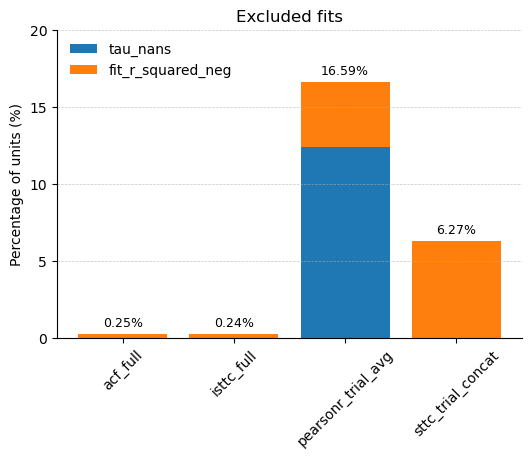

In [62]:
methods = exclusion_df['method']
x = np.arange(len(methods))

#plt.figure(figsize=(6, 4))

fig, axes = plt.subplots(1,1, figsize=(6,4))

axes.bar(x, exclusion_df['percent_tau_nans'], label='tau_nans')
axes.bar(x, exclusion_df['percent_fit_r_squared_neg'], bottom=exclusion_df['percent_tau_nans'], label='fit_r_squared_neg')
axes.set_xticks(x, methods, rotation=45)
axes.set_ylabel('Percentage of units (%)')
axes.set_title('Excluded fits')
axes.legend(frameon = False)
axes.grid(True, which="both", axis='y', linestyle="--", linewidth=0.5, alpha=0.7)
axes.set_yticks([0,5,10,15,20])

total = exclusion_df['exclusion_perc']
for i, (xi, height) in enumerate(zip(x, total)):
    axes.text(xi, height + 0.3, f"{height:.2f}%", ha='center', va='bottom', fontsize=9)

sns.despine()

plt.savefig(fig_folder + 'excluded_fits_plot.png' , bbox_inches='tight', dpi=300)
plt.savefig(fig_folder + 'excluded_fits_plot.svg' , bbox_inches='tight')

In [69]:
nans_neg_r2_df = tau_plot_all_long_df.query('tau.isna() or fit_r_squared < 0')[['unit_id', 'method', 'fr', 'alpha', 'tau_ms_true']].copy()
nans_neg_r2_df

,unit_id,method,fr,alpha,tau_ms_true
997,997,acf_full,0.033065,0.695408,210.248651
1553,1553,acf_full,3.699036,0.148351,280.805644
1836,1836,acf_full,0.015676,0.730262,126.916556
1910,1910,acf_full,0.120057,0.890543,65.975195
2495,2495,acf_full,5.226193,0.165966,249.009988
...,...,...,...,...,...
399952,99952,sttc_trial_concat,5.869952,0.335180,289.960242
399973,99973,sttc_trial_concat,0.143518,0.722081,228.791545
399983,99983,sttc_trial_concat,6.698488,0.262788,212.846140
399984,99984,sttc_trial_concat,0.039075,0.210591,243.583679


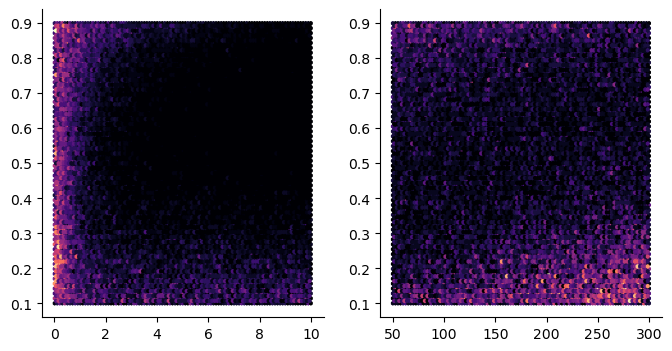

In [74]:
fig, axes = plt.subplots(1,2, figsize=(8,4))

#norm = TwoSlopeNorm(vcenter=0)

hb0 = axes[0].hexbin(
    x=nans_neg_r2_df['fr'], y=nans_neg_r2_df['alpha'], cmap="magma"           
)

hb0 = axes[1].hexbin(
    x=nans_neg_r2_df['tau_ms_true'], y=nans_neg_r2_df['alpha'], cmap="magma"           
)

sns.despine()

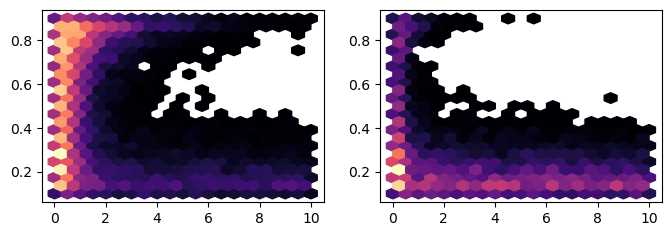

In [89]:
fig, axes = plt.subplots(1,2, figsize=(8,2.5))

df_s1 = nans_neg_r2_df.query('method == "pearsonr_trial_avg"')
df_s2 = nans_neg_r2_df.query('method == "sttc_trial_concat"')

hb0 = axes[0].hexbin(
    x=df_s1['fr'], y=df_s1['alpha'],
    gridsize=20,                
    cmap='magma',
    mincnt=1                    
)

hb1 = axes[1].hexbin(
    x=df_s2['fr'], y=df_s2['alpha'],
    gridsize=20,                
    cmap='magma',
    mincnt=1                    
)

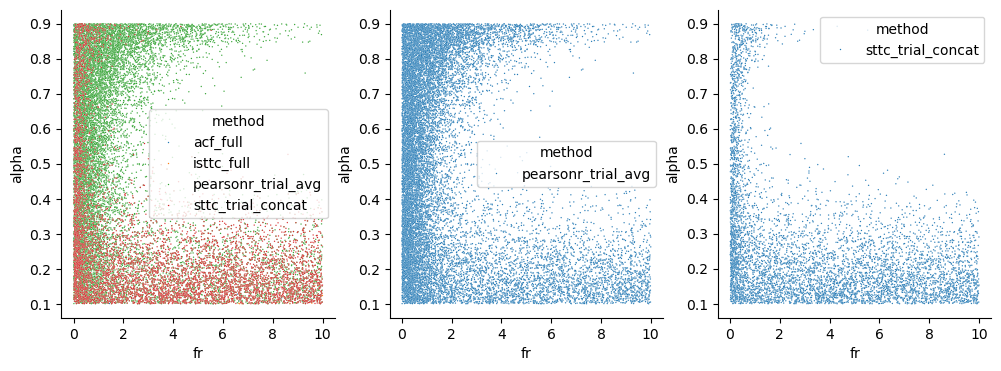

In [82]:
fig, axes = plt.subplots(1,3, figsize=(12,4))


sns.scatterplot(ax=axes[0], x='fr', y='alpha', hue='method', data=nans_neg_r2_df, s=1)

sns.scatterplot(ax=axes[1], x='fr', y='alpha', hue='method', data=nans_neg_r2_df.query('method == "pearsonr_trial_avg"'), s=1)
sns.scatterplot(ax=axes[2], x='fr', y='alpha', hue='method', data=nans_neg_r2_df.query('method == "sttc_trial_concat"'), s=1)

sns.despine()

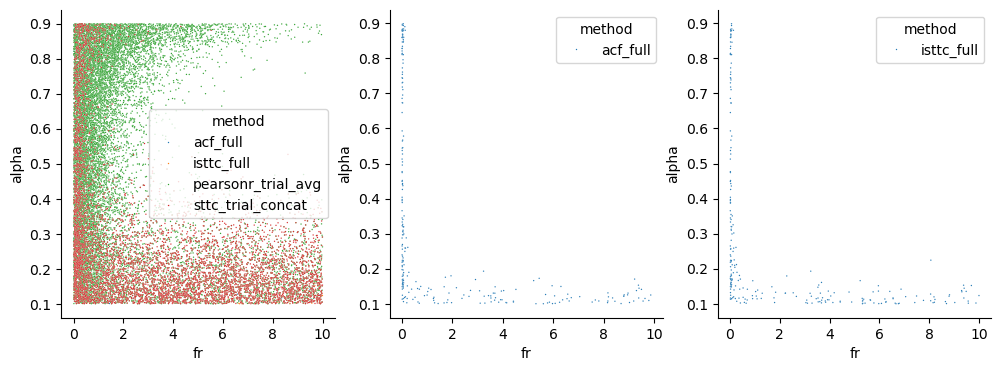

In [124]:
fig, axes = plt.subplots(1,3, figsize=(12,4))


sns.scatterplot(ax=axes[0], x='fr', y='alpha', hue='method', data=nans_neg_r2_df, s=1)

sns.scatterplot(ax=axes[1], x='fr', y='alpha', hue='method', data=nans_neg_r2_df.query('method == "acf_full"'), s=1)
sns.scatterplot(ax=axes[2], x='fr', y='alpha', hue='method', data=nans_neg_r2_df.query('method == "isttc_full"'), s=1)

sns.despine()

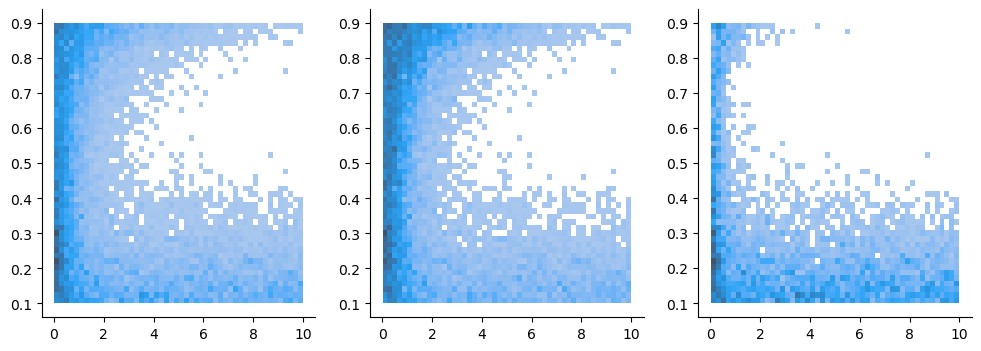

In [100]:
fig, axes = plt.subplots(1,3, figsize=(12,4))

sns.histplot(ax=axes[0], x=nans_neg_r2_df['fr'].values, y=nans_neg_r2_df['alpha'].values, bins=50)

h_1 = sns.histplot(ax=axes[1], x=df_s1['fr'].values, y=df_s1['alpha'].values, bins=50)
sns.histplot(ax=axes[2], x=df_s2['fr'].values, y=df_s2['alpha'].values, bins=50)

sns.despine()

102.0
138.0


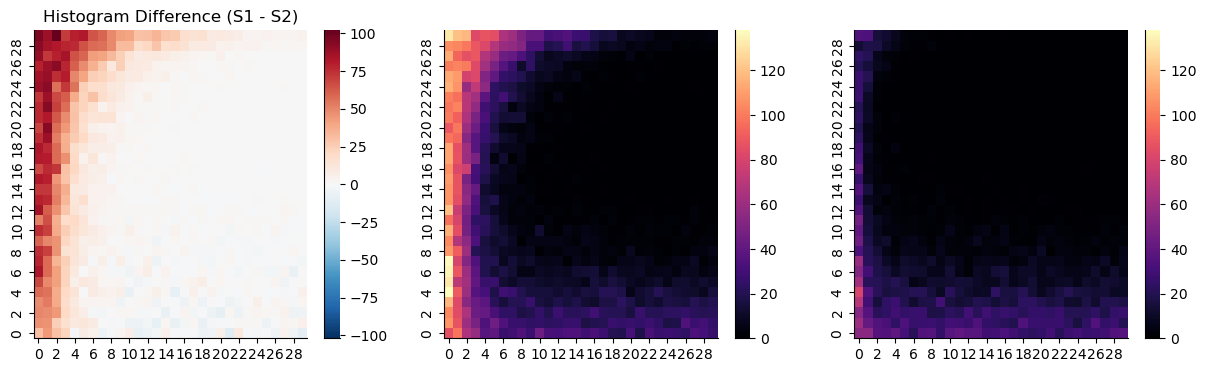

In [128]:
bins = 30
fr_bins = np.linspace(0.01, 10, bins + 1)
alpha_bins = np.linspace(0.1, 0.9, bins + 1)

hist1, _, _ = np.histogram2d(df_s1['fr'], df_s1['alpha'], bins=[fr_bins, alpha_bins])
hist2, _, _ = np.histogram2d(df_s2['fr'], df_s2['alpha'], bins=[fr_bins, alpha_bins])
hist_diff = hist1 - hist2

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

diff_limit = np.max([np.abs(hist_diff.min()), 
                     np.abs(hist_diff.max())])
print(diff_limit)
norm = TwoSlopeNorm(vcenter=0, vmin=-diff_limit, vmax=diff_limit)
sns.heatmap(hist_diff.T, ax=axes[0], cmap="RdBu_r", norm=norm, cbar=True)
axes[0].set_title("Histogram Difference (S1 - S2)")
axes[0].invert_yaxis()


ind_limit = np.max([np.abs(hist1.min()), np.abs(hist2.min()), np.abs(hist1.max()), np.abs(hist2.max())])
print(ind_limit)
sns.heatmap(hist1.T, ax=axes[1], cmap="magma", vmin=0, vmax=ind_limit, cbar=True)
axes[1].invert_yaxis()

sns.heatmap(hist2.T, ax=axes[2], cmap="magma", vmin=0, vmax=ind_limit, cbar=True)
axes[2].invert_yaxis()

sns.despine()

In [131]:
methods_per_unit = nans_neg_r2_df.groupby('unit_id')['method'].nunique()
counts = methods_per_unit.value_counts().sort_index()

print(counts)

method
1    13830
2     4418
3      146
4       61
Name: count, dtype: int64


In [134]:
subset = nans_neg_r2_df[nans_neg_r2_df['method'].isin(['pearsonr_trial_avg', 'sttc_trial_concat'])]
method_counts = subset.groupby('unit_id')['method'].nunique()
both_methods = method_counts[method_counts == 2].index

# Count
num_both = len(both_methods)
print(f"Number of units with both methods: {num_both}")


Number of units with both methods: 4469


In [135]:
included_df = tau_plot_all_long_df.query('tau.notna() and fit_r_squared >= 0').copy()
included_df.groupby(by='method', as_index=False).count()

,method,unit_id,tau,tau_lower,tau_upper,fit_r_squared,acf_decline,tau_ms,fr,alpha,tau_ms_true,tau_diff_abs,tau_diff_rel,ci_zero_excluded
0,acf_full,99752,99752,99752,99752,99752,99752,99752,99752,99752,99752,99752,99752,99752
1,isttc_full,99762,99762,99762,99762,99762,99762,99762,99762,99762,99762,99762,99762,99762
2,pearsonr_trial_avg,83406,83406,83406,83406,83406,83406,83406,83406,83406,83406,83406,83406,83406
3,sttc_trial_concat,93732,93732,93732,93732,93732,93732,93732,93732,93732,93732,93732,93732,93732


In [142]:
acf_decline_df = included_df.groupby('method').agg(
    num_true=('acf_decline', lambda x: x.sum())
).assign(
    total=100000,
    percent_true=lambda x: 100 * x['num_true'] / x['total']
).reset_index()
acf_decline_df

,method,num_true,total,percent_true
0,acf_full,88094,100000,88.094
1,isttc_full,88494,100000,88.494
2,pearsonr_trial_avg,53376,100000,53.376
3,sttc_trial_concat,61431,100000,61.431


In [147]:
acf_decline_df = included_df.groupby('method').agg(
    num_true=('ci_zero_excluded', lambda x: x.sum())
).assign(
    total=100000,
    percent_true=lambda x: 100 * x['num_true'] / x['total']
).reset_index()
acf_decline_df

,method,num_true,total,percent_true
0,acf_full,92695,100000,92.695
1,isttc_full,92500,100000,92.500
2,pearsonr_trial_avg,30387,100000,30.387
3,sttc_trial_concat,38013,100000,38.013


In [149]:
included_df.groupby(by='method', as_index=False)['fit_r_squared'].describe()

,method,count,mean,std,min,25%,50%,75%,max
0,acf_full,99752.0,0.913915,0.148676,0.000003,0.910855,0.980615,0.994065,1.0
1,isttc_full,99762.0,0.912914,0.151332,0.000000,0.910063,0.981381,0.994387,1.0
2,pearsonr_trial_avg,83406.0,0.514422,0.323567,0.000000,0.209936,0.533770,0.820662,1.0
3,sttc_trial_concat,93732.0,0.532294,0.325870,0.000000,0.227438,0.567609,0.840380,1.0


<Axes: xlabel='method', ylabel='fit_r_squared'>

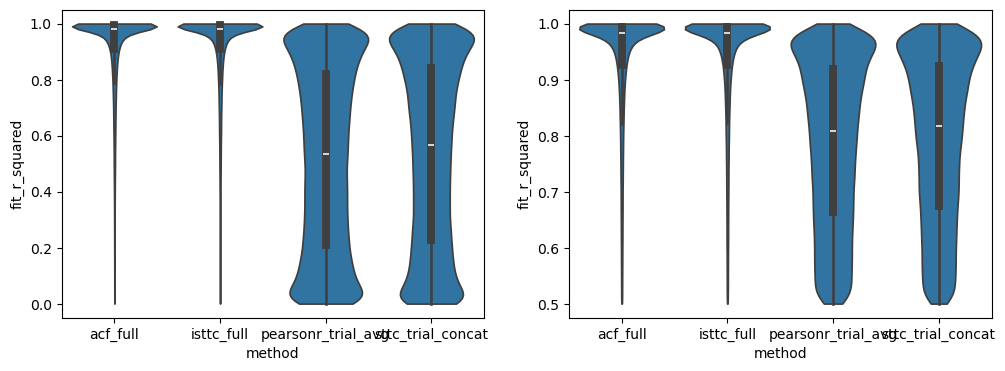

In [146]:
fig, axes = plt.subplots(1,2, figsize=(12,4))

sns.violinplot(ax=axes[0], x='method', y='fit_r_squared', cut=0, density_norm='width', data=included_df)

sns.violinplot(ax=axes[1], x='method', y='fit_r_squared', cut=0, density_norm='width', data=included_df.query('fit_r_squared > 0.5'))

In [ ]:
# do the % Rsquared in 0-0.25, 0.25-0.50, etc

In [153]:
included_df.query('fit_r_squared > 0.5').groupby(by='method', as_index=False)['unit_id'].count() 

,method,unit_id
0,acf_full,96294
1,isttc_full,96128
2,pearsonr_trial_avg,43915
3,sttc_trial_concat,51630


In [163]:
tau_plot_wide_df = included_df.query('method == "pearsonr_trial_avg"').merge(included_df.query('method == "sttc_trial_concat"'), 
                                                                             suffixes=('_acf', '_isttc'), on=['unit_id','fr', 'alpha', 'tau_ms_true'], how='inner')
tau_plot_wide_df.reset_index(inplace=True, drop=True)

print(f'len tau_plot_wide_df {len(tau_plot_wide_df)}')

tau_plot_wide_df.columns

len tau_plot_wide_df 81607


Index(['unit_id', 'tau_acf', 'tau_lower_acf', 'tau_upper_acf',
       'fit_r_squared_acf', 'acf_decline_acf', 'method_acf', 'tau_ms_acf',
       'fr', 'alpha', 'tau_ms_true', 'tau_diff_abs_acf', 'tau_diff_rel_acf',
       'ci_zero_excluded_acf', 'tau_isttc', 'tau_lower_isttc',
       'tau_upper_isttc', 'fit_r_squared_isttc', 'acf_decline_isttc',
       'method_isttc', 'tau_ms_isttc', 'tau_diff_abs_isttc',
       'tau_diff_rel_isttc', 'ci_zero_excluded_isttc'],
      dtype='object')

0.012429335997590439


C:\Users\ipochino\AppData\Local\anaconda3\envs\isttc\Lib\site-packages\numpy\lib\_function_base_impl.py:4809: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


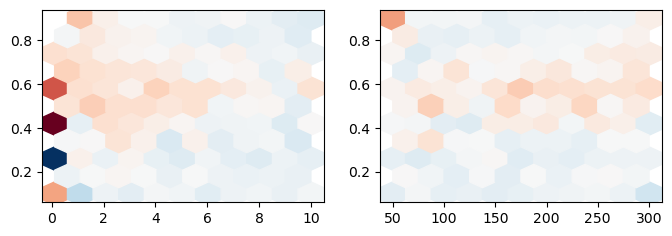

In [164]:
# do this on stats data - unit matched - also wide df
fig, axes = plt.subplots(1,2, figsize=(8,2.5))

norm = TwoSlopeNorm(vcenter=0)

hb0 = axes[0].hexbin(
    x=tau_plot_wide_df['fr'], y=tau_plot_wide_df['alpha'],
    C=tau_plot_wide_df['fit_r_squared_isttc'] - tau_plot_wide_df['fit_r_squared_acf'],
    reduce_C_function=np.median,   
    gridsize=10,                
    cmap='RdBu_r',
    norm = norm,
    mincnt=1                    
)

p95_hb0 = np.percentile(np.abs(hb0.get_array()), 95)
print(p95_hb0)

hb1 = axes[1].hexbin(
    x=tau_plot_wide_df['tau_ms_true'], y=tau_plot_wide_df['alpha'],
    C=tau_plot_wide_df['fit_r_squared_isttc'] - tau_plot_wide_df['fit_r_squared_acf'],
    reduce_C_function=np.median,   
    gridsize=10,                
    cmap='RdBu_r',
    norm = norm,
    mincnt=1   
)


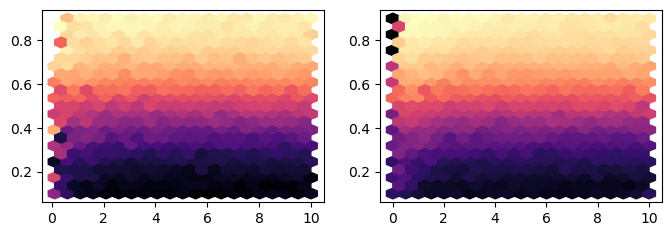

In [159]:
fig, axes = plt.subplots(1,2, figsize=(8,2.5))

norm = TwoSlopeNorm(vcenter=0)

hb0 = axes[0].hexbin(
    x=included_df.query('method == "pearsonr_trial_avg"')['fr'], y=included_df.query('method == "pearsonr_trial_avg"')['alpha'],
    C=included_df.query('method == "pearsonr_trial_avg"')['fit_r_squared'],
    reduce_C_function=np.median,   
    gridsize=20,                
    cmap='magma',
    mincnt=1                    
)

hb1 = axes[1].hexbin(
    x=included_df.query('method == "sttc_trial_concat"')['fr'], y=included_df.query('method == "sttc_trial_concat"')['alpha'],
    C=included_df.query('method == "sttc_trial_concat"')['fit_r_squared'],
    reduce_C_function=np.median,   
    gridsize=20,                
    cmap='magma',
    mincnt=1                    
)

### Export for stats

In [ ]:
tau_plot_all_long_df

In [ ]:
df_no_nan = tau_plot_all_long_df.dropna(subset=['tau'])
df_no_nan = df_no_nan[df_no_nan['fit_r_squared'] >= 0]
# how many methods each unit_id has after dropping NaNs
method_counts = df_no_nan.groupby('unit_id')['method'].nunique()

valid_units = method_counts[method_counts == 4].index
filtered_df = tau_plot_all_long_df[tau_plot_all_long_df['unit_id'].isin(valid_units)]
filtered_df.reset_index(inplace=True, drop=True)

In [ ]:
filtered_df

In [ ]:
ci_df = filtered_df.groupby('method').agg(
    num_true=('zero_excluded', lambda x: x.sum()),
    total=('zero_excluded', 'count')
).assign(
    percent_true=lambda x: 100 * x['num_true'] / x['total']
).reset_index()
ci_df

In [ ]:
filtered_df.to_csv(results_folder + 'tau_plot_all_long_not_nan_df.csv')

### Plots

In [ ]:
color_acf_full = '#718190'
color_isttc_full = '#1ba9e2'
color_pearson_trail_avg = '#f4a91c' 
color_sttc_trail_concat = '#955da2' 

colors = [color_acf_full, color_isttc_full, color_pearson_trail_avg, color_sttc_trail_concat]

In [ ]:
filtered_df.groupby(by='method', as_index=False)['fit_r_squared'].describe()

In [ ]:
filtered_df.groupby(by='method', as_index=False)['acf_decline'].describe()

##### Percentage on NaNs in tau and negative R-squared

In [ ]:
fig, axes = plt.subplots(1,3, figsize=(12,4))

sns.barplot(ax=axes[0], x='method', y='exclusion_perc', data=exclusion_df, palette=['steelblue'])
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)

sns.violinplot(ax=axes[1], x='method', y='fit_r_squared', cut=0, density_norm='width', data=filtered_df)

sns.violinplot(ax=axes[2], x='method', y='fit_r_squared', cut=0, density_norm='width', data=tau_plot_all_long_df.query('fit_r_squared > 0'))

# sns.histplot(ax=axes[1], x=included_df['pearson'].values, y=tau_df_pivot_ac_metric['sttc'].values, bins=250)
# axes[0].plot([0, 1], [0, 1], c='k', transform=axes[0].transAxes)
# axes[0].set_aspect('equal', adjustable='box')
# axes[0].set_xlabel('Pearson R-squared')
# axes[0].set_ylabel('STTC R-squared')

sns.despine()

In [ ]:
tau_plot_all_long_df.query('fit_r_squared > 0').groupby(by='method', as_index=False)['fit_r_squared'].describe()

In [ ]:
filtered_df.groupby(by='method', as_index=False)['fit_r_squared'].describe()

##### R-squared